## Build dataloader

In [1]:
import imageio

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.utils.data
import torchvision.utils as vutils

from connectomics.data.utils import seg_to_aff, collate_fn_target
from connectomics.data.dataset import VolumeDataset
from connectomics.data.augmentation import *

In [2]:
def show_imgs(imgs, label=None, cmap=None):
    plt.figure(figsize=(16,4))
    for i in range(1,5):
        plt.subplot('14%d' % (i))
        if cmap is not None:
            plt.imshow(imgs[i-1], cmap=cmap)
        else:
            plt.imshow(imgs[i-1])
        if label is not None:
            plt.title(label+' '+str(i))
    plt.show()

### 1. Load data

For Harvard Research Computing (RC) cluster users, you can directly access the dsta directory if you have access to the `coxfs01` partition. For external users please check the tutotial for downloading the dataset and change the `data_path` accordingly.

In [3]:
# path to image and label
data_path = '/n/pfister_lab2/Lab/vcg_connectomics/snemi/'
image_path = data_path + 'img/train-input.tif'
label_path = data_path + 'label/train-labels.tif'

# read image and label
image = imageio.volread(image_path).squeeze()
label = imageio.volread(label_path).squeeze()

# print image and label details
print(image.shape, image.ndim, image.dtype)
print(label.shape, label.ndim, label.dtype)

(100, 1024, 1024) 3 uint8
(100, 1024, 1024) 3 uint16


### 2. Build dataloader

In [4]:
model_io_size = (8, 160, 160)
# setup augmentor

augmentor = Compose([Rotate(p=1.0),
                     Rescale(p=1.0),
                     Flip(p=0.0),
                     Elastic(alpha=10.0, p=0.5),
                     MissingParts(p=0.8, iterations=40),
                     MisAlignment(p=1.0),
                     MissingSection(p=1.0),
                     Grayscale()], 
                     input_size = model_io_size,
                     keep_non_smoothed = False)

augmentor = Compose([MisAlignment(p=1.0)], 
                     input_size = model_io_size,
                     keep_non_smoothed = False)

print('data augmentation: ', augmentor is not None)

dataset = VolumeDataset(volume=[image / 255.0], label=[label], sample_volume_size=augmentor.sample_size,
                        sample_label_size=augmentor.sample_size, augmentor=augmentor, mode='train')

img_loader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn_target,
                                         num_workers=1, pin_memory=True)

Sample size required for the augmentor: [ 10 323 323]
Sample size required for the augmentor: [  8 176 176]
data augmentation:  True


(8, 1, 8, 160, 160) (8, 3, 8, 160, 160)


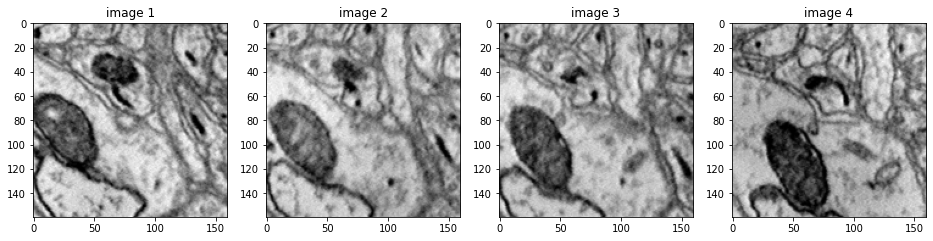

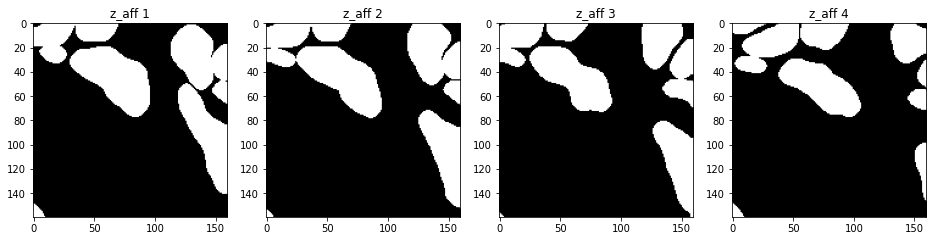

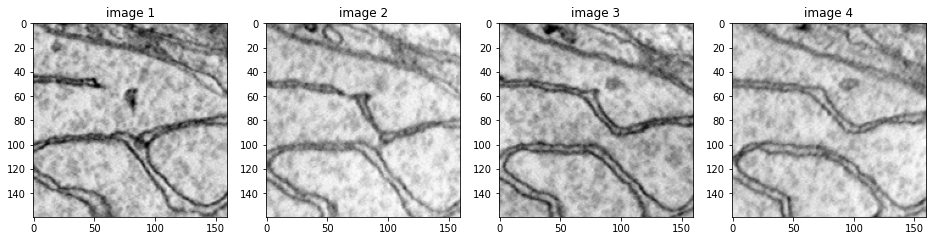

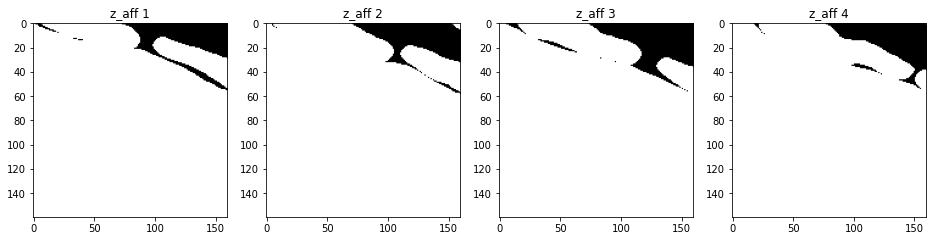

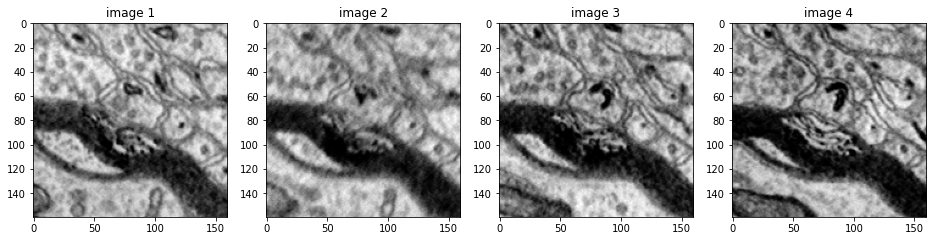

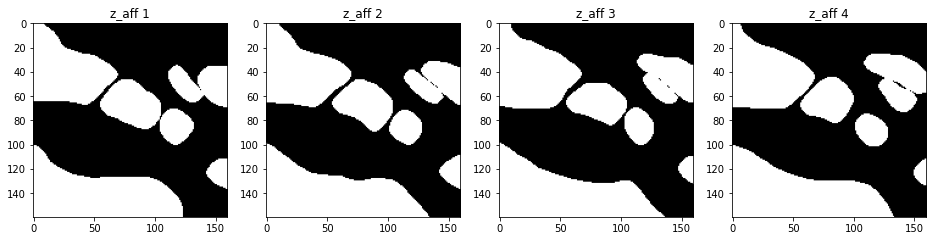

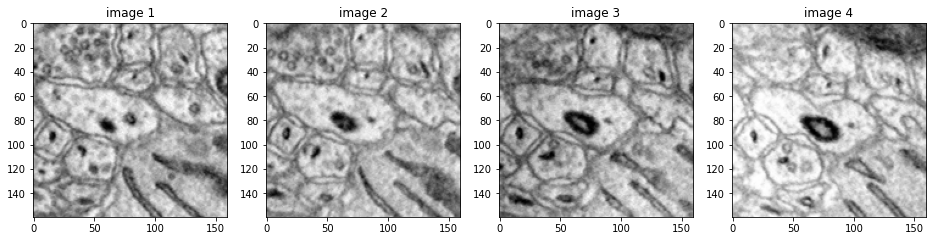

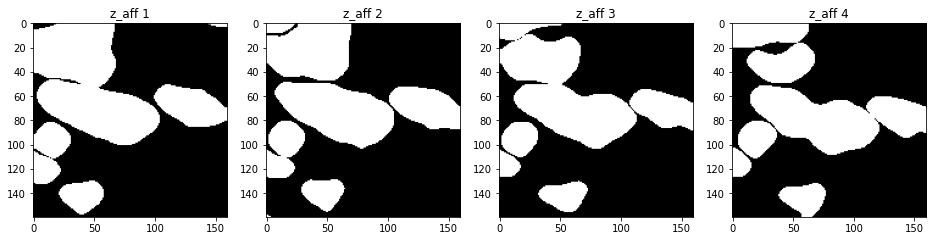

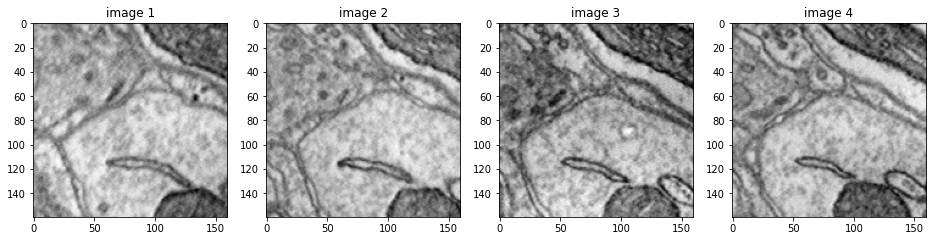

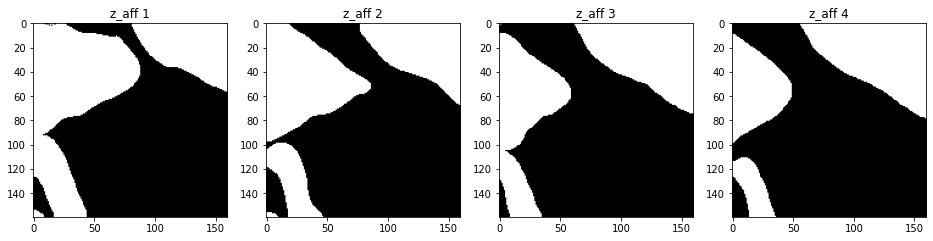

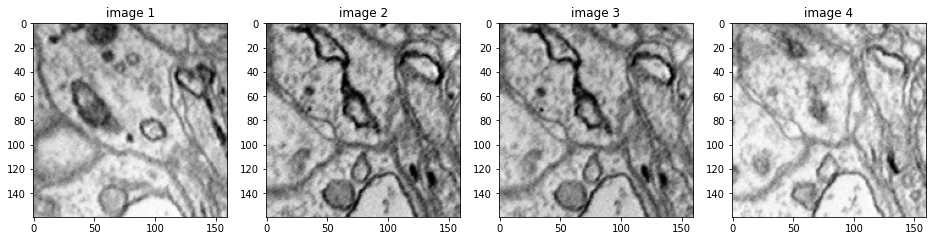

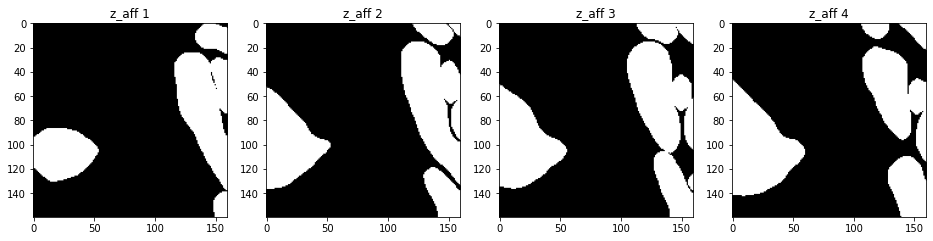

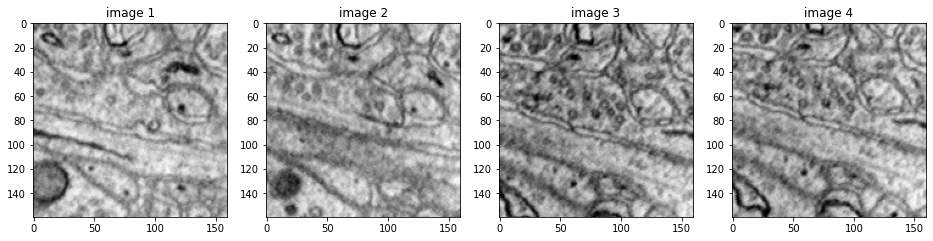

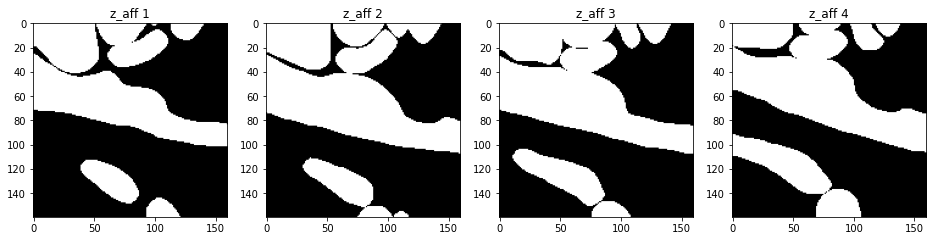

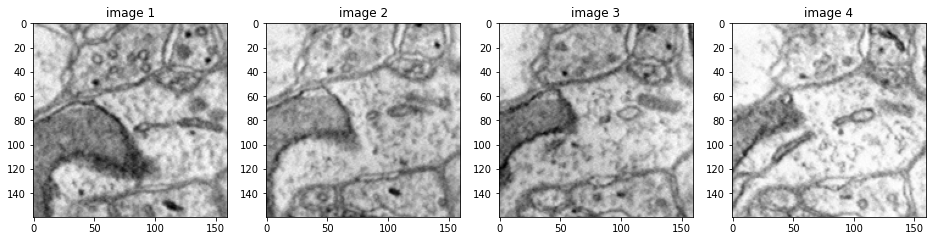

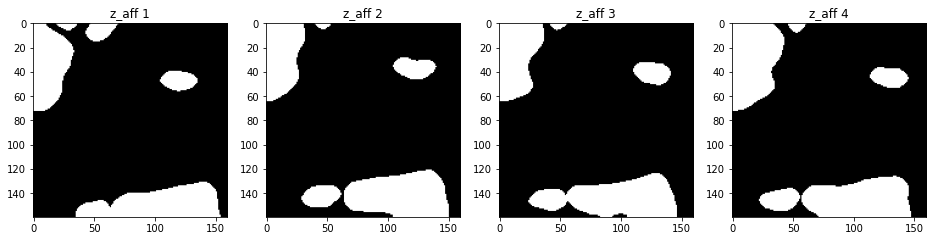

In [5]:
for iteration, (_, volume, label, class_weight) in enumerate(img_loader):
    label = label[0]
    print(volume.shape, label.shape)
    for sample_id in range(volume.shape[0]):
        show_imgs(volume[sample_id, 0, 2:6], 'image', cmap='gray')
        show_imgs(label[sample_id, 0, 2:6], 'z_aff', cmap='gray')
        #show_imgs(label[sample_id, 1, 2:6].detach().numpy(), 'y_aff')
        #show_imgs(label[sample_id, 2, 2:6].detach().numpy(), 'x_aff')
    if iteration == 0:
        break